In [1]:
from numpy import *
from matplotlib.pyplot import *
import matplotlib
import astropy

In [2]:
"""
script for Gaia objects:

SELECT TOP 200000 phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp, ra, ra_error, dec, dec_error, parallax, parallax_over_error, radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val,lum_val,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper
FROM gaiadr2.gaia_source
WHERE random_index<2000000
AND parallax_over_error > 5
AND phot_g_mean_flux_over_error>50
AND phot_rp_mean_flux_over_error>20
AND phot_bp_mean_flux_over_error>20
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND visibility_periods_used>8AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))

script for hipparcos objects
SELECT TOP 100000 hp_mag+5*log10(plx)-10 AS mg, b_v, ra, e_ra_rad, dec, e_de_rad, plx, e_plx
FROM public.hipparcos_newreduction
WHERE (plx/e_plx) > 5
"""

"""
Read in data
"""
f = '1e5_objects_filtered.csv'
d_body = genfromtxt(f, delimiter=',',skip_header=1)
d_head = genfromtxt(f, delimiter=',', max_rows=1, dtype=None, encoding='utf8')
d = {}
for i in range(len(d_head)):
    d[d_head[i]] = d_body[:,i]

fh = 'hip_1e5_objects.csv'
d_body = genfromtxt(fh, delimiter=',',skip_header=1)
d_head = genfromtxt(fh, delimiter=',', max_rows=1, dtype=None, encoding='utf8')
dh = {}
for i in range(len(d_head)):
    dh[d_head[i]] = d_body[:,i]

Text(0.5, 1.0, 'correct when possible')

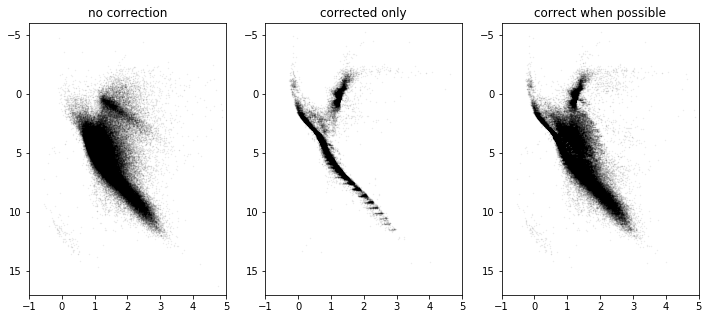

In [3]:
"""
plot HR diagram with/without correction
"""
a = 0.07
ms = 1
figure(figsize=(12,5))
subplot(131)
plot(d['bp_rp'],d['mg'],'k.',alpha=a,ms=ms)
gca().invert_yaxis()
xlim([-1,5])
ylim([17,-6])
title('no correction')
subplot(132)
plot(d['bp_rp']-d['e_bp_min_rp_val'],(d['mg']-d['a_g_val']),'k.',alpha=a,ms=ms)
gca().invert_yaxis()
xlim([-1,5])
ylim([17,-6])
title('corrected only')
subplot(133)
plot(d['bp_rp']-nan_to_num(d['e_bp_min_rp_val']),(d['mg']-nan_to_num(d['a_g_val'])),'k.',alpha=a,ms=ms)
gca().invert_yaxis()
xlim([-1,5])
ylim([17,-6])
title('correct when possible')


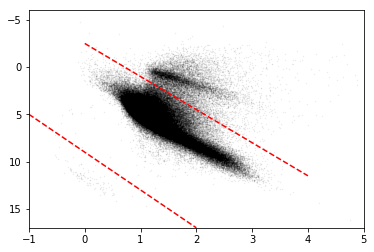

In [4]:
"""
cut in HR diagram to divide into MS + WD + giants
"""

plot(d['bp_rp'],d['mg'],'k.',alpha=a,ms=ms)
gca().invert_yaxis()
xlim([-1,5])
ylim([17,-6])
plot([-1,2],[5,17],'r--')
plot([0,4],[-2.5,11.5],'r--')

is_wd = d['bp_rp']<(.25*(d['mg']-5)-1)
is_g = d['bp_rp']>(4/14*(d['mg']+2.5))
#plot(d['bp_rp'],d['mg']*is_wd,'r.',alpha=a,ms=ms)
#plot(d['bp_rp'],d['mg']*is_g,'b.',alpha=a,ms=ms)

In [5]:
distance_in_pc = 1/(d['parallax']/1e3)

(20, 8)

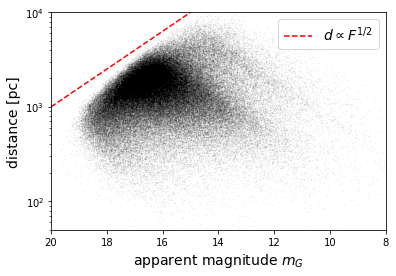

In [6]:
"""
magnitude vs. distance:
distance for parallax is ~ linearly to flux
"""
plot(d['mg']-5*log10(d['parallax'])+10,distance_in_pc,'k.',alpha=.05,ms=1)
yscale('log')
gca().invert_xaxis()
y0 = 1
p,=plot([20,15],[1e3*y0,1e4*y0],'r--')
xlabel(r'apparent magnitude $m_G$',size=14)
ylabel('distance [pc]',size=14)
legend([p],[r'$d\propto F^{1/2}$'],fontsize=14)
ylim([5e1,1e4])
xlim([20,8])

In [7]:
"""
function for selecting part of data
"""
def apply_filter(y,f):
    r = y*f
    r[r == 0] = nan
    return r
is_wd = d['bp_rp']<(.25*(d['mg']-5)-1)
is_g = d['bp_rp']>(4/14*(d['mg']+2.5))

In [8]:
"""
percentage of each class of objects
"""
print(sum(is_wd)/len(d['mg']))
print(sum(is_g)/len(d['mg']))
print(1-sum(is_wd)/len(d['mg'])-sum(is_g)/len(d['mg']))

0.0007165396646043185
0.08530266911025065
0.9139807912251451


In [9]:
"""
transform to galactic coord
"""
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactocentric  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

c = SkyCoord(frame=ICRS, ra=d['ra']*u.deg, dec=d['dec']*u.deg, distance=1/d['parallax']*u.kpc, obstime='J2015.5')

In [10]:
gc = c.transform_to(Galactocentric)
(x,y,z) = (gc.x.value,gc.y.value,gc.z.value)

In [11]:
"""
function for schematically plotting the galaxy
"""
R_b = 2 # kpc
R_d = 15
H_d = 0.5
def plot_galaxy(c='grey'):
    x1 = linspace(-R_d,R_d,100)
    y1 = maximum(sqrt(1-(x1/R_d)**2)*H_d, nan_to_num(sqrt(1-(x1/R_b)**2)*R_b))
    plot(x1,y1,color=c)
    plot(x1,-y1,color=c)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


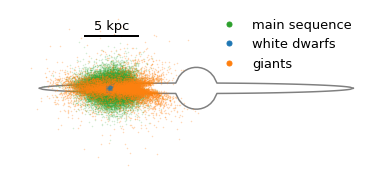

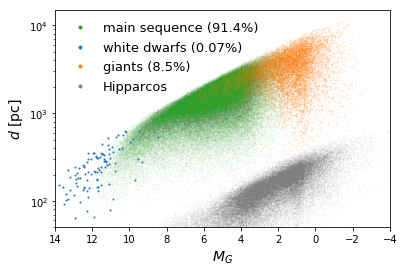

In [13]:
"""
make the plots
"""
figure(figsize=(6,3))
plot_galaxy()
plot(x,apply_filter(z,1-is_wd-is_g),'.',color='tab:green',alpha=.2,ms=1)
plot(x,apply_filter(z,is_g),'.',color='tab:orange',alpha=.3,ms=1)
plot(x,apply_filter(z,is_wd),'.',color='tab:blue',alpha=.2,ms=1)
axis('equal')
p1,=plot([],[],'.',color='tab:green',ms=10)
p2,=plot([],[],'.',color='tab:blue',ms=10)
p3,=plot([],[],'.',color='tab:orange',ms=10)
legend([p1,p2,p3],['main sequence','white dwarfs','giants'],loc=1,fontsize=13,
      frameon=False)
xlim([-16,16])
ylim([-5,5])
axis('off')

x0 = -8.1
z0 = 5
plot([x0-2.5,x0+2.5],[z0,z0],'k',lw=2)
text(x0,z0+0.3,'5 kpc',size=13,ha='center',va='bottom')



figure(figsize=(6,4))
plot(d['mg'],apply_filter(distance_in_pc,1-is_wd-is_g),'.',color='tab:green',alpha=.03,ms=1)
plot(d['mg'],apply_filter(distance_in_pc,is_wd),'.',color='tab:blue',alpha=1,ms=2)
plot(d['mg'],apply_filter(distance_in_pc,is_g),'.',color='tab:orange',alpha=.15,ms=1)

plot(dh['mg'],1/(dh['plx']/1e3),'.',color='grey',alpha=.05,ms=1)

p1,=plot([],[],'.',color='tab:green')
p2,=plot([],[],'.',color='tab:blue')
p3,=plot([],[],'.',color='tab:orange')
p4,=plot([],[],'.',color='grey')
legend([p1,p2,p3,p4],['main sequence (91.4%)','white dwarfs (0.07%)','giants (8.5%)','Hipparcos'],loc=2,fontsize=13,
      frameon=False)
gca().invert_xaxis()
yscale('log')
xlabel(r'$M_G$',size=14)
ylabel(r'$d$ [pc]',size=14)
ylim([5e1,1.5e4])
xlim([14,-4])
#title('white dwarfs',size=14)
show()